# Step 1: Grid, States, Action, Rewards Environment Setup

In [1]:
import numpy as np

# Grid definition
grid_size = 5
states = [(i, j) for i in range(grid_size) for j in range(grid_size)]
actions = ['up', 'down', 'left', 'right']

# Reward and transition setups
rewards = np.zeros((grid_size, grid_size))
transitions = {}

for i in range(grid_size):
    for j in range(grid_size):
        transitions[(i, j)] = {}
        for action in actions:
            if action == 'up':
                next_state = (max(i-1, 0), j)
            elif action == 'down':
                next_state = (min(i+1, grid_size-1), j)
            elif action == 'left':
                next_state = (i, max(j-1, 0))
            elif action == 'right':
                next_state = (i, min(j+1, grid_size-1))

            if (i, j) == (0, 1):  # Blue square
                transitions[(i, j)][action] = [(3, 2)], 5  # Red square
            elif (i, j) == (0, 4):  # Green square
                transitions[(i, j)][action] = [(3, 2), (4, 4)], 2.5  # Red or Yellow square
            elif (i, j) == next_state:  # Edge of the grid
                transitions[(i, j)][action] = [next_state], -0.5
            else:
                transitions[(i, j)][action] = [next_state], 0


# Step 2: Implement Value Function Estimation Methods


#1. Solving Bellman Equations Explicitly



In [2]:
def solve_bellman_equations(states, transitions, gamma=0.95):
    n = len(states)
    A = np.zeros((n, n))
    b = np.zeros(n)

    for idx, state in enumerate(states):
        A[idx, idx] = 1  # Set the diagonal to 1
        for action in actions:
            next_states, reward = transitions[state][action]
            if isinstance(next_states, list):  # Check if there's a list of next states
                prob = 1 / len(next_states)  # Even probability distribution
                for ns in next_states:
                    next_idx = states.index(ns)
                    A[idx, next_idx] -= prob * gamma / 4
                    b[idx] += prob * reward / 4
            else:
                next_idx = states.index(next_states[0])
                A[idx, next_idx] -= gamma / 4
                b[idx] += reward / 4

    v = np.linalg.solve(A, b)
    return v.reshape((grid_size, grid_size))

value_function_1 = solve_bellman_equations(states, transitions)
print(value_function_1)


[[ 2.17100208  4.7336156   2.07028049  1.26529444  1.77912239]
 [ 1.1180732   1.7821227   1.17409573  0.739174    0.56246548]
 [ 0.16279444  0.47788999  0.35198379  0.11045592 -0.18617038]
 [-0.54699155 -0.28473257 -0.28040463 -0.43990985 -0.7443105 ]
 [-1.10787684 -0.84936779 -0.80799244 -0.93799278 -1.23723244]]


#Iterative Policy Evaluation


In [3]:
def iterative_policy_evaluation(states, transitions, gamma=0.95, theta=0.01):
    V = np.zeros((grid_size, grid_size))
    delta = float('inf')

    while delta > theta:
        delta = 0
        for state in states:
            v = V[state]
            V[state] = 0
            for action in actions:
                next_states, reward = transitions[state][action]
                if isinstance(next_states, list):  # Handle cases with multiple next states
                    expected_value = 0
                    for ns in next_states:
                        expected_value += V[ns]
                    expected_value /= len(next_states)
                    V[state] += 0.25 * (reward + gamma * expected_value)
                else:  # Handle cases with a single next state
                    V[state] += 0.25 * (reward + gamma * V[next_states])
            delta = max(delta, abs(v - V[state]))
    return V

value_function_2 = iterative_policy_evaluation(states, transitions)
print(value_function_2)


[[ 1.10806943  5.04740722  1.55755016  0.97101195  2.30884379]
 [ 0.65194838  1.74041512  1.07337121  0.75302015  0.81554629]
 [ 0.13990298  0.5657149   0.47535718  0.31487324  0.1397923 ]
 [-0.20000689  0.0334068   0.05224873 -0.03937885 -0.22843237]
 [-0.41773246 -0.27326461 -0.24661337 -0.30257428 -0.45169888]]


#Value Iteration


In [4]:
def value_iteration(states, transitions, gamma=0.95, theta=0.01):
    V = np.zeros((grid_size, grid_size))
    delta = float('inf')

    while delta > theta:
        delta = 0
        for state in states:
            v = V[state]
            values = []
            for action in actions:
                next_states, reward = transitions[state][action]
                if isinstance(next_states, list):  # Handle cases with multiple next states
                    expected_value = 0
                    for ns in next_states:
                        expected_value += reward + gamma * V[ns]  # Calculate value for each possible next state
                    expected_value /= len(next_states)  # Average the values
                    values.append(expected_value)
                else:  # Handle cases with a single next state
                    values.append(reward + gamma * V[next_states])
            V[state] = max(values)
            delta = max(delta, abs(v - V[state]))
    return V

value_function_3 = value_iteration(states, transitions)
print(value_function_3)


[[20.97066342 22.08073642 20.9766996  19.92786462 18.3626664 ]
 [19.92213025 20.9766996  19.92786462 18.93147139 17.98489782]
 [18.92602373 19.92786462 18.93147139 17.98489782 17.08565293]
 [17.97972255 18.93147139 17.98489782 17.08565293 16.23137028]
 [17.08073642 17.98489782 17.08565293 16.23137028 15.41980177]]


#Visualization

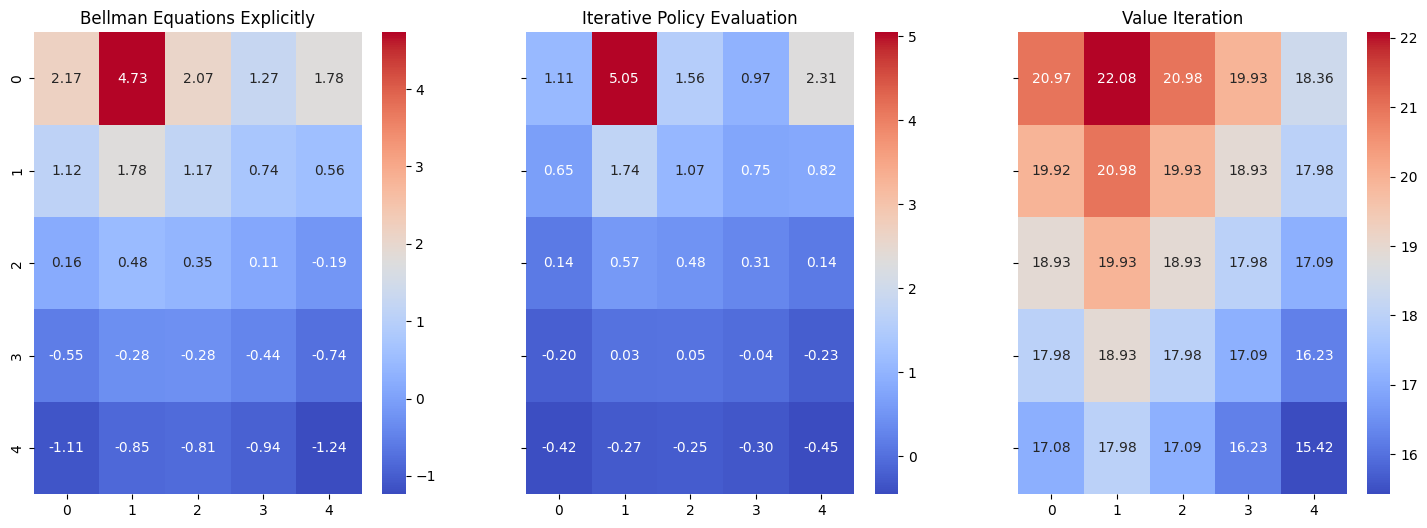

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot each heatmap
sns.heatmap(value_function_1, ax=ax[0], annot=True, cmap='coolwarm', fmt=".2f")
ax[0].set_title('Bellman Equations Explicitly')

sns.heatmap(value_function_2, ax=ax[1], annot=True, cmap='coolwarm', fmt=".2f")
ax[1].set_title('Iterative Policy Evaluation')

sns.heatmap(value_function_3, ax=ax[2], annot=True, cmap='coolwarm', fmt=".2f")
ax[2].set_title('Value Iteration')

# Display the plot
plt.show()


Solving the System of Bellman Equations Explicitly

In [6]:
highest_value_1 = np.max(value_function_1)
highest_value_states_1 = np.argwhere(value_function_1 == highest_value_1)
print("Highest Value (Bellman):", highest_value_1)
print("Highest Value States (Bellman):", highest_value_states_1)


Highest Value (Bellman): 4.733615602061509
Highest Value States (Bellman): [[0 1]]


Iterative Policy Evaluation


In [7]:
highest_value_2 = np.max(value_function_2)
highest_value_states_2 = np.argwhere(value_function_2 == highest_value_2)
print("Highest Value (Iterative):", highest_value_2)
print("Highest Value States (Iterative):", highest_value_states_2)


Highest Value (Iterative): 5.047407220046799
Highest Value States (Iterative): [[0 1]]


Value Iteration

In [8]:
highest_value_3 = np.max(value_function_3)
highest_value_states_3 = np.argwhere(value_function_3 == highest_value_3)
print("Highest Value (Value Iteration):", highest_value_3)
print("Highest Value States (Value Iteration):", highest_value_states_3)


Highest Value (Value Iteration): 22.08073642052355
Highest Value States (Value Iteration): [[0 1]]


#State with Highest Value

**Solving the System of Bellman Equations Explicitly**

The highest value is 4.7336156, located at state (0, 1), which is the blue square.

**Iterative Policy Evaluation**

The highest value is 5.04740722, also at state (0, 1), the blue square.

**Value Iteration**

The highest value is 22.08073642, again at state (0, 1), the blue square.

**Conclusion**

Across all three methods, the state (0, 1)—the blue square—consistently shows the highest value. This indicates that the blue square, due to its high reward and beneficial transition to the red square, is the most valuable state in this gridworld setup. This consistency across different valuation methods reinforces the strategy of aiming to reach or exploit this state to maximize returns in the gridworld environment.

# Determine The Optimal Policy

#Solving the Bellman Optimality Equation Explicitly

In [9]:
def derive_policy_from_values(states, transitions, V, gamma=0.95):
    policy = np.zeros((grid_size, grid_size), dtype=object)

    for i in range(grid_size):
        for j in range(grid_size):
            state = (i, j)
            best_action = None
            best_value = -float('inf')

            for action in actions:
                action_value = 0
                next_states, reward = transitions[state][action]

                if len(next_states) > 1:  # Handle probabilistic outcomes
                    sum_values = sum(V[ns] for ns in next_states) / len(next_states)
                    action_value = reward + gamma * sum_values
                else:
                    next_state = next_states[0]  # Get the single next state
                    action_value = reward + gamma * V[next_state]

                # Update the best action if this action is better
                if action_value > best_value:
                    best_value = action_value
                    best_action = action

            policy[i, j] = best_action

    return policy

# Derive the optimal policy using the Bellman optimality equation
bellman_optimal_policy = derive_policy_from_values(states, transitions, value_function_1)
print(bellman_optimal_policy)


[['right' 'up' 'left' 'left' 'up']
 ['up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up']]


#Policy Iteration with Iterative Policy Evaluation

In [10]:
def iterative_policy_evaluation(states, transitions, policy, gamma=0.95, theta=0.01):
    V = np.zeros((grid_size, grid_size))
    delta = float('inf')

    while delta > theta:
        delta = 0
        for state in states:
            v = V[state]
            V[state] = 0
            for action in actions:
                next_states, reward = transitions[state][action]
                if isinstance(next_states, list):  # Handle cases with multiple next states
                    expected_value = 0
                    for ns in next_states:
                        expected_value += V[ns]
                    expected_value /= len(next_states)
                    V[state] += 0.25 * (reward + gamma * expected_value)
                else:  # Handle cases with a single next state
                    V[state] += 0.25 * (reward + gamma * V[next_states])
            delta = max(delta, abs(v - V[state]))
    return V

def policy_iteration(states, transitions, gamma=0.95, theta=0.01):
    policy = np.random.choice(actions, size=(grid_size, grid_size))
    stable = False

    while not stable:
        # Policy Evaluation
        V = iterative_policy_evaluation(states, transitions, policy, gamma)
        stable = True

        # Policy Improvement
        for state in states:
            old_action = policy[state]
            best_action = None
            best_value = -float('inf')

            for action in actions:
                total_value = 0
                next_states, reward = transitions[state][action]
                for ns in next_states:
                    prob = 1 / len(next_states)
                    total_value += prob * (reward + gamma * V[ns])

                if total_value > best_value:
                    best_value = total_value
                    best_action = action

            policy[state] = best_action
            if old_action != best_action:
                stable = False

    return policy, V

ip_optimal_policy, optimal_values_pi = policy_iteration(states, transitions)
print(ip_optimal_policy)



[['right' 'up' 'left' 'right' 'up']
 ['right' 'up' 'left' 'left' 'up']
 ['up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up']]


#Policy Improvement with Value Iteration

In [11]:
def value_iteration_and_policy_improvement(states, transitions, gamma=0.95, theta=0.01):
    V = np.zeros((grid_size, grid_size))
    policy = np.zeros((grid_size, grid_size), dtype='object')

    while True:
        delta = 0
        for state in states:
            v = V[state]
            best_value = -float('inf')
            for action in actions:
                total_value = 0
                next_states, reward = transitions[state][action]
                for ns in next_states:
                    prob = 1 / len(next_states)
                    total_value += prob * (reward + gamma * V[ns])

                if total_value > best_value:
                    best_value = total_value
                    policy[state] = action

            delta = max(delta, abs(v - best_value))
            V[state] = best_value

        if delta < theta:
            break

    return policy, V

vi_optimal_policy, optimal_values_vi = value_iteration_and_policy_improvement(states, transitions)
print(vi_optimal_policy)


[['right' 'up' 'left' 'left' 'up']
 ['up' 'up' 'up' 'up' 'left']
 ['up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up']
 ['up' 'up' 'up' 'up' 'up']]


#Visualization of Policies

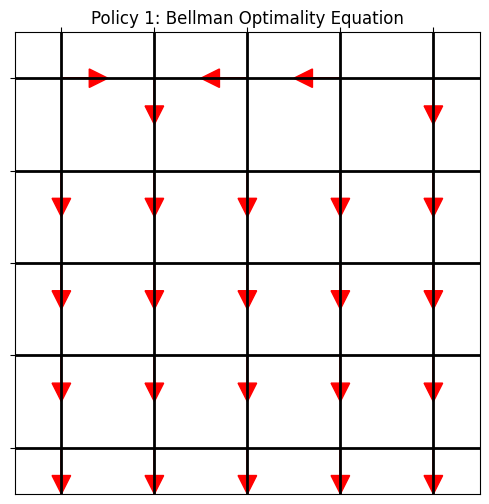

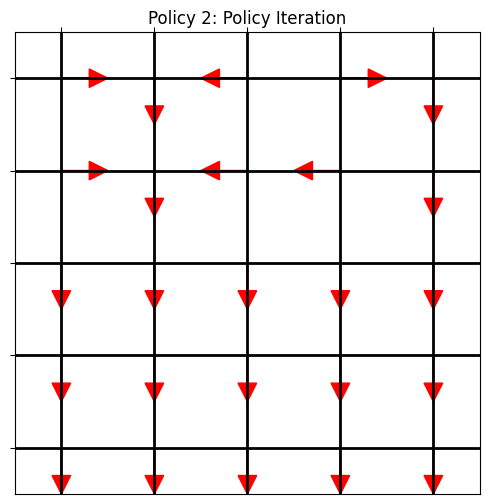

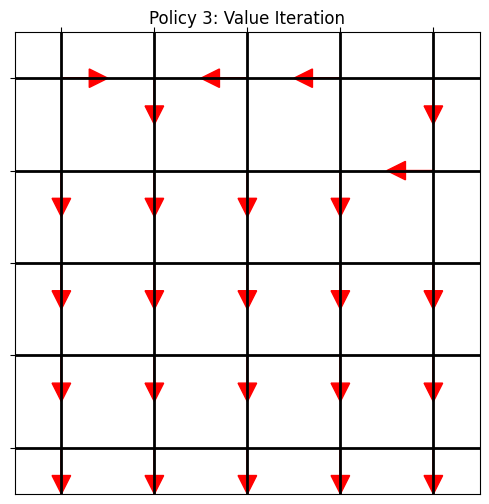

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_policy(policy, title="Optimal Policy"):
    # Create a figure and axis with a size suitable for the grid
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-0.5, 4.5)
    ax.set_ylim(-0.5, 4.5)
    ax.grid(which='major', color='black', linestyle='-', linewidth=2)

    # Set up the axes to match the grid layout
    ax.set_xticks(np.arange(0, 5, 1))
    ax.set_yticks(np.arange(0, 5, 1))
    ax.xaxis.tick_top()
    ax.invert_yaxis()

    # Hide the ticks
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Direction vectors for arrows
    directions = {
        'up': (0, 1),
        'down': (0, -1),
        'left': (-1, 0),
        'right': (1, 0)
    }

    # Plot an arrow for each cell according to the policy direction
    for y in range(grid_size):
        for x in range(grid_size):
            dx, dy = directions[policy[y][x]]
            ax.arrow(x, y, dx*0.3, dy*0.3, color='red', head_width=0.2, head_length=0.2)

    plt.title(title)
    plt.show()

# Visualize each policy
plot_policy(bellman_optimal_policy, "Policy 1: Bellman Optimality Equation")
plot_policy(ip_optimal_policy, "Policy 2: Policy Iteration")
plot_policy(vi_optimal_policy, "Policy 3: Value Iteration")


# Part 2 Tasks

#Grid, States, Action, Rewards Environment Setup

In [13]:
import numpy as np

# Define grid dimensions and terminal states
grid_size = 5
terminal_states = [(2, 4), (4, 0)]  # Define terminal states

# Initialize rewards and transitions
rewards = np.full((grid_size, grid_size), -0.2)  # Default reward for any movement
transitions = {}

for i in range(grid_size):
    for j in range(grid_size):
        transitions[(i, j)] = {}
        if (i, j) in terminal_states:
            for action in ['up', 'down', 'left', 'right']:
                transitions[(i, j)][action] = ((i, j), 0)  # Terminal state transitions to itself with 0 reward
        else:
            for action in ['up', 'down', 'left', 'right']:
                if action == 'up':
                    next_state = (max(i-1, 0), j)
                elif action == 'down':
                    next_state = (min(i+1, grid_size-1), j)
                elif action == 'left':
                    next_state = (i, max(j-1, 0))
                elif action == 'right':
                    next_state = (i, min(j+1, grid_size-1))

                # Handle special states
                if (i, j) == (0, 1):  # Blue square
                    transitions[(i, j)][action] = [(3, 2)], 5  # Jump to Red square
                elif (i, j) == (0, 4):  # Green square
                    transitions[(i, j)][action] = [(3, 2), (4, 4)], 2.5  # Jump to Red or Yellow square
                # Handle all other states
                else:
                    if next_state in terminal_states:
                        transitions[(i, j)][action] = [next_state], 0
                    elif (i, j) == next_state:  # Edge of the grid, moves back to itself
                        transitions[(i, j)][action] = [next_state], -0.2
                    else:
                        transitions[(i, j)][action] = [next_state], rewards[next_state]

def is_terminal(state):
    return state in terminal_states

def get_next_state(state, action):
    i, j = state
    if action == 'up':
        return (max(i-1, 0), j)
    elif action == 'down':
        return (min(i+1, grid_size-1), j)
    elif action == 'left':
        return (i, max(j-1, 0))
    elif action == 'right':
        return (i, min(j+1, grid_size-1))

print("Transitions:", transitions)


Transitions: {(0, 0): {'up': ([(0, 0)], -0.2), 'down': ([(1, 0)], -0.2), 'left': ([(0, 0)], -0.2), 'right': ([(0, 1)], -0.2)}, (0, 1): {'up': ([(3, 2)], 5), 'down': ([(3, 2)], 5), 'left': ([(3, 2)], 5), 'right': ([(3, 2)], 5)}, (0, 2): {'up': ([(0, 2)], -0.2), 'down': ([(1, 2)], -0.2), 'left': ([(0, 1)], -0.2), 'right': ([(0, 3)], -0.2)}, (0, 3): {'up': ([(0, 3)], -0.2), 'down': ([(1, 3)], -0.2), 'left': ([(0, 2)], -0.2), 'right': ([(0, 4)], -0.2)}, (0, 4): {'up': ([(3, 2), (4, 4)], 2.5), 'down': ([(3, 2), (4, 4)], 2.5), 'left': ([(3, 2), (4, 4)], 2.5), 'right': ([(3, 2), (4, 4)], 2.5)}, (1, 0): {'up': ([(0, 0)], -0.2), 'down': ([(2, 0)], -0.2), 'left': ([(1, 0)], -0.2), 'right': ([(1, 1)], -0.2)}, (1, 1): {'up': ([(0, 1)], -0.2), 'down': ([(2, 1)], -0.2), 'left': ([(1, 0)], -0.2), 'right': ([(1, 2)], -0.2)}, (1, 2): {'up': ([(0, 2)], -0.2), 'down': ([(2, 2)], -0.2), 'left': ([(1, 1)], -0.2), 'right': ([(1, 3)], -0.2)}, (1, 3): {'up': ([(0, 3)], -0.2), 'down': ([(2, 3)], -0.2), 'left':

#Monte Carlo with Exploring Starts

In [14]:
import random

# Initialize value function
V = np.zeros((grid_size, grid_size))
gamma = 0.95
episodes = 10000

policy = lambda s: random.choice(['up', 'down', 'left', 'right'])

# Monte Carlo method with exploring starts
def monte_carlo_es(policy, V, rewards, gamma, episodes):
    for episode in range(episodes):
        state = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))
        while is_terminal(state):
            state = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))
        episode = []
        while not is_terminal(state):
            action = random.choice(['up', 'down', 'left', 'right'])
            # Get the list of possible next states and rewards
            possible_transitions = transitions[state][action]
            # Handle cases where transitions are defined differently
            if isinstance(possible_transitions[0], tuple):  # If the first element is a tuple (state, reward)
                next_state, reward = possible_transitions[0]
            else:  # If the first element is a list of states and the second is the reward
                next_state = random.choice(possible_transitions[0])  # Randomly choose from possible next states
                reward = possible_transitions[1]
            episode.append((state, action, reward))
            state = next_state
        G = 0
        for state, action, reward in reversed(episode):
            G = gamma * G + reward
            # Update value function
            V[state] += (G - V[state]) / episodes
    return V

V = monte_carlo_es(policy, V, rewards, gamma, episodes)
print("Value Function (Monte Carlo Exploring Starts):")
print(V)

Value Function (Monte Carlo Exploring Starts):
[[ 0.48820887  1.34205944  0.34100071  0.07691799  0.20950241]
 [ 0.03243931  0.2535639  -0.08124301 -0.16073801  0.0077194 ]
 [-0.44098543 -0.4897517  -0.64062061 -0.43755198  0.        ]
 [-0.42965716 -0.80985546 -1.18214367 -1.04515251 -0.75940064]
 [ 0.         -0.65061562 -1.22228771 -1.35165957 -1.33394428]]


#Monte Carlo with ϵ-soft Policy

In [15]:
def policy(state):
    return random.choice(['up', 'down', 'left', 'right'])  # Ensure policy always returns a valid action

# Monte Carlo method with ϵ-soft policy
def monte_carlo_epsilon_soft(policy, V, rewards, gamma, epsilon, episodes):
    for episode in range(episodes):
        state = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))
        while is_terminal(state):
            state = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))
        episode = []
        while not is_terminal(state):
            if random.uniform(0, 1) < epsilon:
                action = random.choice(['up', 'down', 'left', 'right'])
            else:
                # Call the policy function to get the action
                action = policy(state)
            # Access transitions and handle different formats
            transition = transitions[state][action]
            if isinstance(transition[0], tuple):
                next_state, reward = transition[0]
            else:
                next_state = random.choice(transition[0])
                reward = transition[1]
            episode.append((state, action, reward))
            state = next_state
        G = 0
        for state, action, reward in reversed(episode):
            G = gamma * G + reward
            # Update value function
            V[state] += (G - V[state]) / episodes
    return V

epsilon = 0.1

V = np.zeros((grid_size, grid_size))
V = monte_carlo_epsilon_soft(policy, V, rewards, gamma, epsilon, episodes)
print("Value Function (Monte Carlo ϵ-soft):")
print(V)

Value Function (Monte Carlo ϵ-soft):
[[ 0.46167237  1.32987767  0.34268731  0.06040612  0.20786492]
 [ 0.06492276  0.23335501 -0.10490032 -0.16743283  0.01220561]
 [-0.40784041 -0.49236371 -0.65610017 -0.4527093   0.        ]
 [-0.42009469 -0.81501932 -1.19882955 -1.059709   -0.76476878]
 [ 0.         -0.64977295 -1.23971117 -1.37503603 -1.35132189]]


#Behaviour Policy with Equiprobable Moves

In [16]:
# Behaviour Policy with Equiprobable Moves
def behaviour_policy(grid_size, episodes, gamma=0.95):
    policy = np.ones((grid_size, grid_size, 4)) / 4  # Equiprobable policy
    Q = np.zeros((grid_size, grid_size, 4))
    C = np.zeros((grid_size, grid_size, 4))

    actions = ['up', 'down', 'left', 'right']
    action_to_idx = {action: idx for idx, action in enumerate(actions)}

    def get_action(state):
        return random.choice(actions)

    for episode in range(episodes):
        state = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))
        while is_terminal(state):
            state = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))

        episode = []
        while not is_terminal(state):
            action = random.choice(['up', 'down', 'left', 'right'])
            # Get the list of possible next states and rewards
            possible_transitions = transitions[state][action]
            # Handle cases where transitions are defined differently
            if isinstance(possible_transitions[0], tuple):  # If the first element is a tuple (state, reward)
                next_state, reward = possible_transitions[0]
            else:  # If the first element is a list of states and the second is the reward
                next_state = random.choice(possible_transitions[0])  # Randomly choose from possible next states
                reward = possible_transitions[1]
            episode.append((state, action, reward))
            state = next_state

        G = 0
        W = 1
        for state, action, reward in reversed(episode):
            G = gamma * G + reward
            action_idx = action_to_idx[action]
            C[state][action_idx] += W
            Q[state][action_idx] += (W / C[state][action_idx]) * (G - Q[state][action_idx])
            policy[state] = np.eye(4)[np.argmax(Q[state])]
            if action != np.argmax(policy[state]):
                break
            W /= 0.25  # Since behaviour policy is equiprobable
    return policy

policy = behaviour_policy(grid_size, episodes, gamma)
print("Optimal Policy (Behaviour Policy):")
print(policy)


Optimal Policy (Behaviour Policy):
[[[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [1.   0.   0.   0.  ]]

 [[0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [1.   0.   0.   0.  ]
  [0.25 0.25 0.25 0.25]]

 [[1.   0.   0.   0.  ]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [1.   0.   0.   0.  ]]

 [[0.25 0.25 0.25 0.25]
  [1.   0.   0.   0.  ]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]
  [0.25 0.25 0.25 0.25]]]


#Policy Iteration with Permuted Squares

In [17]:
# Policy Iteration with Permuted Squares
def policy_iteration_permuted(grid_size, iterations, gamma=0.95, permute_prob=0.1):
    policy = np.ones((grid_size, grid_size, 4)) / 4  # Equiprobable policy initially
    V = np.zeros((grid_size, grid_size))

    actions = ['up', 'down', 'left', 'right']
    action_to_idx = {action: idx for idx, action in enumerate(actions)}

    def get_next_state(state, action):
        i, j = state
        if action == 'up':
            return (max(i-1, 0), j)
        elif action == 'down':
            return (min(i+1, grid_size-1), j)
        elif action == 'left':
            return (i, max(j-1, 0))
        elif action == 'right':
            return (i, min(j+1, grid_size-1))

    for iteration in range(iterations):
        # Policy Evaluation
        while True:
            delta = 0
            for i in range(grid_size):
                for j in range(grid_size):
                    state = (i, j)
                    if is_terminal(state):
                        continue
                    v = V[state]
                    new_v = sum([policy[state][action_to_idx[action]] *
                                 (rewards[state] + gamma * V[get_next_state(state, action)])
                                 for action in actions])
                    V[state] = new_v
                    delta = max(delta, abs(v - new_v))
            if delta < 1e-6:
                break

        # Policy Improvement
        policy_stable = True
        for i in range(grid_size):
            for j in range(grid_size):
                state = (i, j)
                if is_terminal(state):
                    continue
                old_action = np.argmax(policy[state])
                action_values = np.zeros(4)
                for action in actions:
                    next_state = get_next_state(state, action)
                    action_values[action_to_idx[action]] = rewards[state] + gamma * V[next_state]
                best_action = np.argmax(action_values)
                policy[state] = np.eye(4)[best_action]
                if old_action != best_action:
                    policy_stable = False

        if policy_stable:
            break

        # Permute Green and Blue squares with probability 0.1
        if np.random.rand() < permute_prob:
            # Swap locations of green and blue squares
            rewards[(0, 1)], rewards[(0, 4)] = rewards[(0, 4)], rewards[(0, 1)]

    return policy

policy = policy_iteration_permuted(grid_size, 100, gamma)
print("Optimal Policy (Policy Iteration with Permuted Squares):")
print(policy)

Optimal Policy (Policy Iteration with Permuted Squares):
[[[0.   1.   0.   0.  ]
  [0.   1.   0.   0.  ]
  [0.   1.   0.   0.  ]
  [0.   1.   0.   0.  ]
  [0.   1.   0.   0.  ]]

 [[0.   1.   0.   0.  ]
  [0.   1.   0.   0.  ]
  [0.   1.   0.   0.  ]
  [0.   1.   0.   0.  ]
  [0.   1.   0.   0.  ]]

 [[0.   1.   0.   0.  ]
  [0.   1.   0.   0.  ]
  [0.   0.   0.   1.  ]
  [0.   0.   0.   1.  ]
  [0.25 0.25 0.25 0.25]]

 [[0.   1.   0.   0.  ]
  [0.   1.   0.   0.  ]
  [1.   0.   0.   0.  ]
  [1.   0.   0.   0.  ]
  [1.   0.   0.   0.  ]]

 [[0.25 0.25 0.25 0.25]
  [0.   0.   1.   0.  ]
  [0.   0.   1.   0.  ]
  [1.   0.   0.   0.  ]
  [1.   0.   0.   0.  ]]]


#Plotting Functions

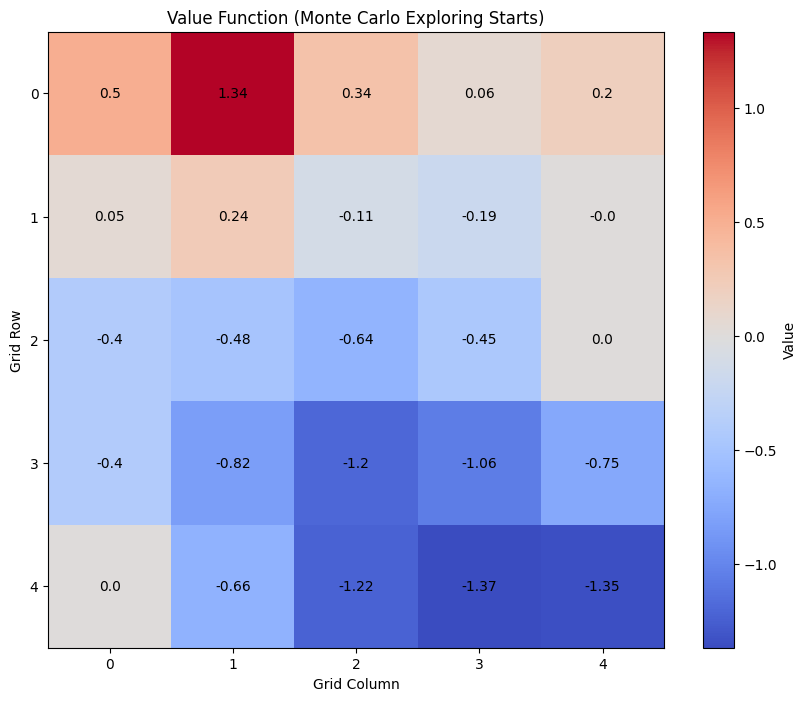

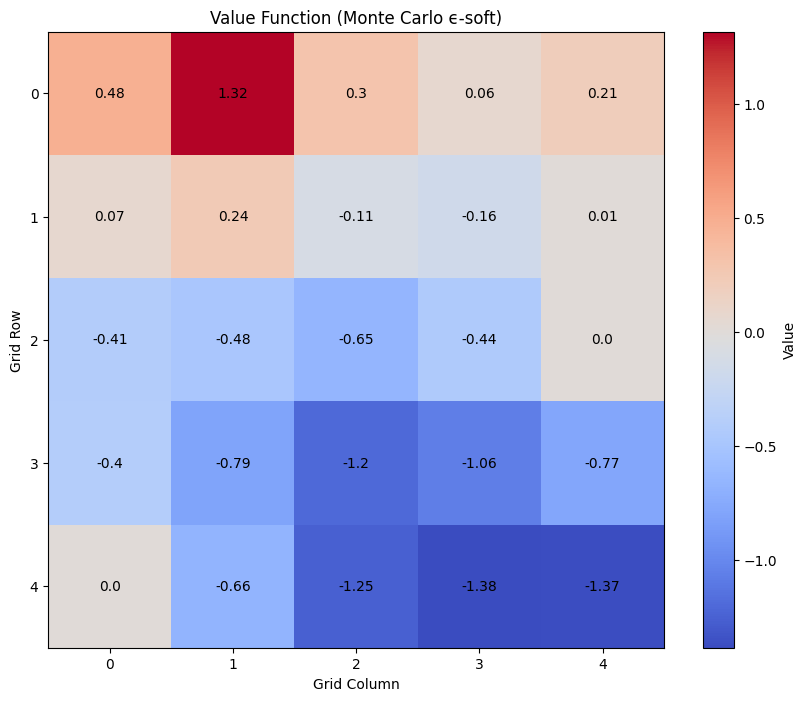

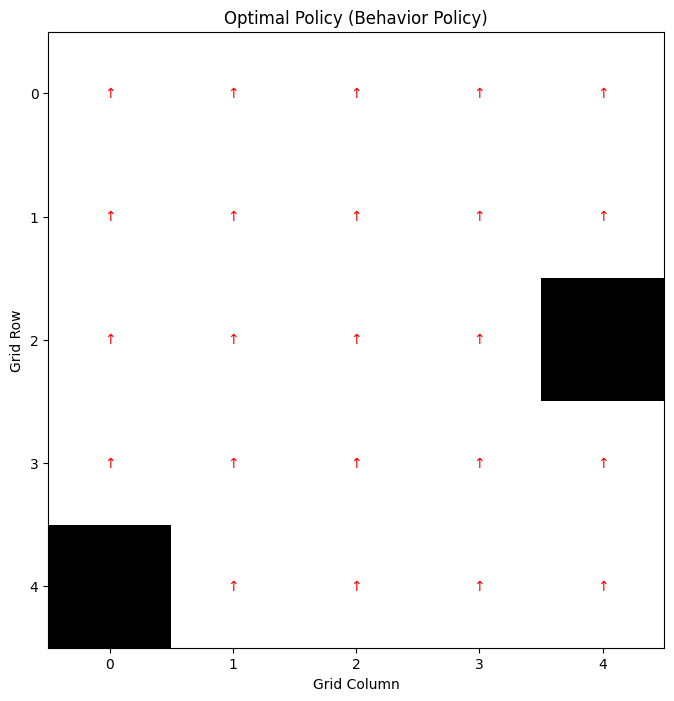

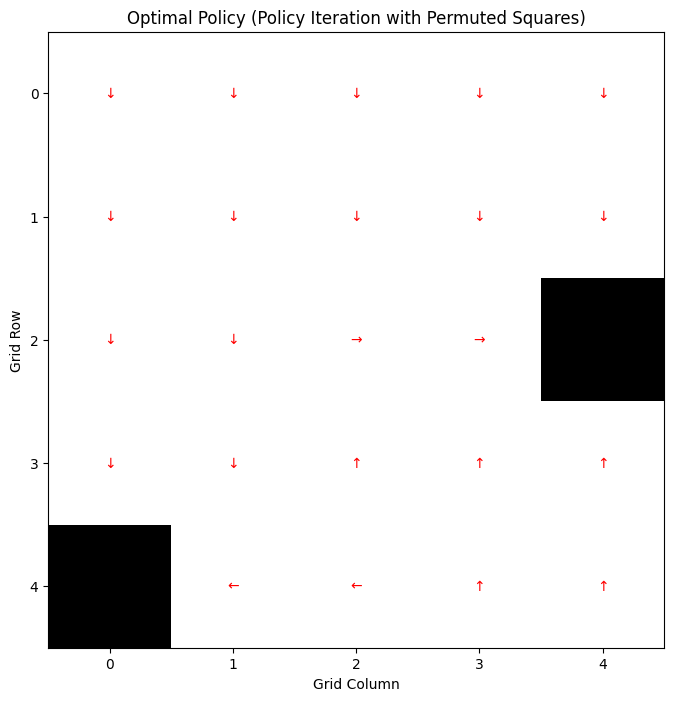

In [18]:
import matplotlib.pyplot as plt

# Plotting function for value functions
def plot_value_function(V, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(V, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label='Value')
    plt.title(title)
    plt.xlabel('Grid Column')
    plt.ylabel('Grid Row')
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            plt.text(j, i, round(V[i, j], 2), ha='center', va='center', color='black')
    plt.show()

# Plotting function for policies
def plot_policy(policy, title):
    plt.figure(figsize=(10, 8))
    grid = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            if is_terminal((i, j)):
                grid[i, j] = -1  # Mark terminal states
    plt.imshow(grid, cmap='gray', interpolation='nearest')
    plt.title(title)
    plt.xlabel('Grid Column')
    plt.ylabel('Grid Row')

    actions = ['↑', '↓', '←', '→']
    for i in range(grid_size):
        for j in range(grid_size):
            if not is_terminal((i, j)):
                best_action = np.argmax(policy[i, j])
                plt.text(j, i, actions[best_action], ha='center', va='center', color='red')
    plt.show()

# Monte Carlo with Exploring Starts
V_es = monte_carlo_es(lambda s: random.choice(['up', 'down', 'left', 'right']), np.zeros((grid_size, grid_size)), rewards, gamma, episodes)
plot_value_function(V_es, "Value Function (Monte Carlo Exploring Starts)")

# Monte Carlo with ϵ-soft Policy
def random_policy(state):
    return random.choice(['up', 'down', 'left', 'right'])  # Ensure policy always returns a valid action

V_eps_soft = monte_carlo_epsilon_soft(random_policy, np.zeros((grid_size, grid_size)), rewards, gamma, epsilon, episodes)
plot_value_function(V_eps_soft, "Value Function (Monte Carlo ϵ-soft)")

# Behavior Policy with Equiprobable Moves
policy_behavior = behaviour_policy(grid_size, episodes, gamma)
plot_policy(policy_behavior, "Optimal Policy (Behavior Policy)")

# Policy Iteration with Permuted Squares
policy_permuted = policy_iteration_permuted(grid_size, 100, gamma)
plot_policy(policy_permuted, "Optimal Policy (Policy Iteration with Permuted Squares)")
